In [1]:
# Imports
import pandas as pd
import numpy as np
import json
import seaborn as sns
pd.set_option('display.max_rows', 400)

In [2]:
# Helper functions from helper_functions.py (couldn't import for some reason)

def set_nulls(data):
    """
   @param data: dataframe
   
   @return dataframe with -99 replaced with NaN
    """
    data.replace(to_replace = -99, value = np.nan, inplace = True)
    data.replace(to_replace = -99.0, value = np.nan, inplace = True)
    data.replace(to_replace = '-99', value= np.nan, inplace = True)      
    return data

def map_cpt(data, column, replace, name):
    """
    @param data: dataframe
    @param column: string, column name
    @param replace: list of variables holding the values to be replaced by that particular variable name
    @ param name: string or integer of what will replace the values in replacements

    """
    for r in replace:
        idx = np.where(data[column] == r)[0]
        data[column].loc[idx] = name
    
    return data

In [3]:
data = pd.read_csv('../data/monet_output.csv')
data.drop(['Unnamed: 0', 'X'], axis = 1, inplace = True)
#df_clean = set_nulls(data)
df_clean = data
op1 = ['COLCT TOT ABDL W/O PRCTECT W/CONTINENT ILEOST']
op2 = ['COLCT TOT ABDL W/O PRCTECT W/ILEOST/ILEOPXTS', 'LAPS COLECTOMY TOT W/O PRCTECT W/ILEOST/ILEOPXTS']
op3 = ['COLECTOMY PARTIAL W/ANASTOMOSIS', 'LAPAROSCOPY COLECTOMY PARTIAL W/ANASTOMOSIS']
op4 = ['COLECTOMY PRTL ABDOMINAL & TRANSANAL APPROACH', 'COLECTOMY PRTL ABDOMINAL & TRANSANAL APPR']
op5 = ['COLECTOMY PRTL W/COLOPROCTOSTOMY', 'LAPS COLECTOMY PRTL W/COLOPXTSTMY LW ANAST']
op6 = ['COLECTOMY PRTL W/COLOPROCTOSTOMY & COLOSTOMY', 'LAPS COLECTMY PRTL W/COLOPXTSTMY LW ANAST W/CLST']
op7 = ['COLECTOMY PRTL W/COLOST/ILEOST & MUCOFISTULA']
op8 = ['COLECTOMY PRTL W/END COLOSTOMY & CLSR DSTL SGMT', 'COLECTOMY PRTL W/END COLOSTOMY&CLSR DSTL SGMT', 'LAPS COLECTOMY PRTL W/END CLST & CLSR DSTL SGM', 'LAPS COLECTOMY PRTL W/END CLST&CLSR DSTL SGM']
op9 = ['COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOS', 'COLECTOMY PRTL W/RMVL TERMINAL ILEUM&ILEOCOLOST', 'LAPS COLECTOMY PRTL W/RMVL TERMINAL ILEUM', 'COLECTOMY PRTL W/RMVL TERMINAL ILEUM & ILEOCOLOST']
op10 = ['COLECTOMY PRTL W/SKIN LEVEL CECOST/COLOSTOMY']
num_replacements = [op1, op2, op3, op4, op5, op6, op7, op8, op9, op10]
for i in range(len(num_replacements)):
    df_clean = map_cpt(df_clean, 'PRNCPTX', num_replacements[i], i+1)

MIS = ['Laparoscopic', 'Endoscopic w/ unplanned conversion to open', 'Hybrid', 'Hybrid w/ open assist', 'Laparoscopic Hand Assisted', 'Laparoscopic w/ open assist', 'Laparoscopic w/ unplanned conversion to open', 'Laparoscopic w/ unplanned conversion to Open', 'Other MIS approach', 'Robotic', 'Robotic w/ open assist', 'Robotic w/ unplanned conversion to open', 'SILS', 'SILS w/ open assist', 'SILS w/ unplanned conversion to open', 'Hybrid w/ unplanned conversion to open', 'Endoscopic w/ open assist', 'Other MIS approach w/ open assist', 'Endoscopic', 'NOTES', 'NOTES w/ open assist', 'Other MIS approach w/ unplanned conversion to open', 'NOTES w/ unplanned conversion to open']
Open = ['Open', 'Open (planned)']
options = [MIS, Open]
names = ['MIS', 'open']
for i in range(len(options)):
    df_clean = map_cpt(df_clean, 'COL_APPROACH', options[i], names[i])

#convert unknowns to NAs
nulls = np.where(df_clean.COL_APPROACH == 'Unknown')[0]
df_clean.COL_APPROACH.loc[nulls] = np.nan

unplanned = [c for c in df_clean if "UNPLANNEDREADMISSION" in c]
df_clean['num_unplanned'] = df_clean[unplanned].sum(axis=1)
df_clean['target'] = [1 if x>0 else 0 for x in df_clean['num_unplanned']]

othercpt = [c for c in df_clean if "OTHERCPT" in c]
df_clean['num_other_procs'] = df_clean[othercpt].count(axis=1)
concurrcpt = [c for c in df_clean if "CONCURR" in c]
df_clean['num_concurr_procs'] = df_clean[concurrcpt].count(axis=1)

/Users/saraokun/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (10,17,19,23,25,27,28,29,30,32,33,36,37,38,39,40,41,42,43,50,51,83,86,89,92,94,95,97,100,103,106,110,113,116,121,124,127,130,133,136,188,190,201,212,231,232,242,244,247,249,256,262,267,273,279,280,281,282,283,284,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,305,318,320,333,334) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/saraokun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [4]:
f = open('../data/data_cleaning.json',)
clean_dict = json.load(f)

In [5]:
cols_to_drop = clean_dict['cols_to_drop']
df_clean.drop(columns=cols_to_drop, inplace=True)

In [6]:
def ensure_before_readmission(df, day_col, binary_col, cols_to_drop=[]):
    # Create a variable to check if readmission is before the particular column by setting null values extremely high
    days_to_readmission = df_clean['READMPODAYS1'].fillna(999)
    df.loc[(days_to_readmission - df_clean[day_col])<=0, binary_col] = 0
    dropcols = cols_to_drop + [day_col]
    df.drop(columns=dropcols, inplace=True)
    return df

In [7]:
ensure_dict = clean_dict['ensure_before_readmission']
for binary_col in ensure_dict.keys():
    df_clean = ensure_before_readmission(df_clean, ensure_dict[binary_col]['day_col'], binary_col, ensure_dict[binary_col]['cols_to_drop'])

In [8]:
df_clean.shape

(257913, 107)

In [9]:
#binarizing SEX variable
df_clean.SEX.replace('male', 0, inplace = True)
df_clean.SEX.replace('female', 1, inplace = True)
df_clean.SEX.replace('non-bi', np.nan, inplace = True)

df_clean.rename(columns={'SEX': 'female'}, inplace = True)

df_clean.INOUT.replace('Inpatient', 1, inplace = True)
df_clean.INOUT.replace('Outpatient', 0, inplace = True)
df_clean.rename(columns = {'INOUT': 'inpatient'}, inplace = True)

df_clean['insulin'] = df_clean.DIABETES
df_clean.insulin.replace(['NON-INSULIN','NO'], 0, inplace = True)
df_clean.insulin.replace('INSULIN', 1, inplace = True)

df_clean.DIABETES.replace(['NON-INSULIN', 'INSULIN'], 1, inplace = True)
df_clean.DIABETES.replace('NO', 0, inplace = True)
df_clean.rename(columns = {'DIABETES': 'diabetes'}, inplace = True)

df_clean["bmi"] = (df_clean.WEIGHT/2.205)/((df_clean.HEIGHT/39.37)**2)

df_clean.drop(['HEIGHT', 'WEIGHT'], axis = 1, inplace = True)

df_clean.REOPERATION2.replace(np.nan, 0, inplace = True)

df_clean.drop(['num_unplanned'], axis = 1, inplace = True)

#target in disguise--leakage
df_clean.drop(['READMPODAYS1', 'CASEID'], axis = 1, inplace = True)

In [10]:
df_clean.shape

(257913, 104)

# Target Correlation

In [68]:
target_corr = df_clean.corr()['target'].sort_values(ascending = False)

In [22]:
target_corr[0:21]

target          1.000000
OTHBLEED        0.363637
OTHSYSEP        0.215155
ORGSPCSSI       0.201094
RETORPODAYS     0.194705
RETURNOR        0.187300
SUPINFEC        0.177046
OTHSESHOCK      0.166088
REOPERATION1    0.162578
COL_ILEUS       0.143845
FAILWEAN        0.143522
URNINFEC        0.138374
OUPNEUMO        0.138325
OTHDVT          0.112178
REINTUB         0.098318
OTHCDIFF        0.091848
CDMI            0.084529
DEHIS           0.083142
RENAINSF        0.081643
MORBPROB        0.078516
OSSIPATOS       0.078178
Name: target, dtype: float64

In [21]:
correlations = df_clean.corr()
perc = correlations.abs().describe()
df_corr = df_clean[perc.columns[(perc.loc["75%"] >= 0.09).values].to_list() + ["target"]].corr()

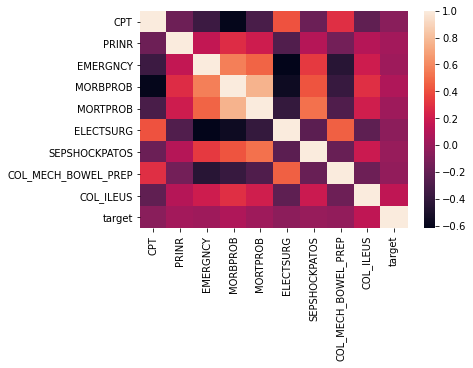

In [22]:
sns.heatmap(df_corr)

In [109]:
df_clean.shape

(257913, 137)

# Fixing stuff from week 5 ppt

In [11]:
df_clean.dropna(subset = ['AGE','female'], inplace = True)

In [12]:
idx = np.where(df_clean.BLEEDDIS.isnull() == False)[0]
replace = df_clean.BLEEDDIS.iloc[idx]
df_clean.BLEEDIS.iloc[idx] = replace

/Users/saraokun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [13]:
df_clean.drop('BLEEDDIS', axis = 1, inplace = True)

In [14]:
df_clean.reset_index(inplace = True, drop = True)

In [15]:
df_clean.isnull().sum()

female                      0
PRNCPTX                     0
CPT                         0
WORKRVU                     0
inpatient                   0
TRANST                    271
ANESTHES                   10
SURGSPEC                    2
diabetes                    0
SMOKE                       0
DYSPNEA                     0
FNSTATUS2                1027
VENTILAT                    0
HXCOPD                      0
ASCITES                     0
HXCHF                       0
HYPERMED                    0
RENAFAIL                    0
DIALYSIS                    0
DISCANCR                    0
WNDINF                      0
STEROID                     0
WTLOSS                      0
TRANSFUS                    0
PRSEPIS                     0
PRSODM                      0
PRBUN                       0
PRCREAT                     0
PRALBUM                     0
PRBILI                      0
PRSGOT                      0
PRALKPH                     0
PRWBC                       0
PRHCT     

In [16]:
df_clean.shape

(253773, 103)

# OHE 

In [17]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

def le_ohe(data, features):
    le = LabelEncoder()
    encodings = {}
    for c in features:
        data[c] = le.fit_transform(data[c].astype(str))
        encodings[c] = dict(zip(le.classes_, le.transform(le.classes_)))
    
    import json
    with open('encodings.txt', 'w') as mappings:
         for key, value in encodings.items(): 
            mappings.write('%s:%s\n' % (key, value))
    
    ohe = OneHotEncoder(drop = 'first')
    ohe.fit(data[features]) 
    ohe_labels = ohe.transform(data[features]).toarray()
    df_cat = pd.DataFrame(ohe_labels, columns = ohe.get_feature_names(features))
    print(df_cat.shape)

    data.drop(features, axis = 1, inplace = True)
    print(data.shape)
    clean_data = pd.concat([data, df_cat], axis = 1)
    return clean_data

#get categorical features
cat_feat = [col for col in df_clean.columns if (df_clean[col].dtype == 'O') or (df_clean[col].isnull().sum() != 0)]

#ohe
clean_data = le_ohe(df_clean, cat_feat)

(253773, 224)
(253773, 76)


In [18]:
clean_data.isnull().sum()

female                   0
CPT                      0
WORKRVU                  0
inpatient                0
diabetes                 0
SMOKE                    0
VENTILAT                 0
HXCOPD                   0
ASCITES                  0
HXCHF                    0
HYPERMED                 0
RENAFAIL                 0
DIALYSIS                 0
DISCANCR                 0
WNDINF                   0
STEROID                  0
WTLOSS                   0
TRANSFUS                 0
PRSODM                   0
PRBUN                    0
PRCREAT                  0
PRALBUM                  0
PRBILI                   0
PRSGOT                   0
PRALKPH                  0
PRWBC                    0
PRHCT                    0
PRPLATE                  0
EMERGNCY                 0
OPTIME                   0
TOTHLOS                  0
SUPINFEC                 0
WNDINFD                  0
ORGSPCSSI                0
DEHIS                    0
OUPNEUMO                 0
REINTUB                  0
P

In [19]:
#handle the -99
clean_data = set_nulls(clean_data)
clean_data.isnull().sum()

female                       0
CPT                          0
WORKRVU                      0
inpatient                    0
diabetes                     0
SMOKE                        0
VENTILAT                     0
HXCOPD                       0
ASCITES                      0
HXCHF                        0
HYPERMED                     0
RENAFAIL                     0
DIALYSIS                     0
DISCANCR                     0
WNDINF                       0
STEROID                      0
WTLOSS                       0
TRANSFUS                     0
PRSODM                   16702
PRBUN                    24348
PRCREAT                  15189
PRALBUM                  68915
PRBILI                   69020
PRSGOT                   73884
PRALKPH                  69110
PRWBC                    12751
PRHCT                    11065
PRPLATE                  12997
EMERGNCY                     0
OPTIME                      58
TOTHLOS                   1629
SUPINFEC                     0
WNDINFD 

In [20]:
nulls = [col for col in clean_data.columns if (clean_data[col].isnull().sum() != 0)]
nulls

['PRSODM',
 'PRBUN',
 'PRCREAT',
 'PRALBUM',
 'PRBILI',
 'PRSGOT',
 'PRALKPH',
 'PRWBC',
 'PRHCT',
 'PRPLATE',
 'OPTIME',
 'TOTHLOS',
 'AGE',
 'HTOODAY',
 'DOPTODIS']

In [21]:
clean_data.dropna(subset = ['AGE', 'OPTIME'], inplace = True)

In [22]:
nulls = [col for col in clean_data.columns if (clean_data[col].isnull().sum() != 0)]
nulls

['PRSODM',
 'PRBUN',
 'PRCREAT',
 'PRALBUM',
 'PRBILI',
 'PRSGOT',
 'PRALKPH',
 'PRWBC',
 'PRHCT',
 'PRPLATE',
 'TOTHLOS',
 'HTOODAY',
 'DOPTODIS']

In [118]:
clean_data.isnull().sum().sort_values()

female                       0
COL_NODESEVAL_6              0
COL_NODESEVAL_5              0
COL_NODESEVAL_4              0
COL_NODESEVAL_3              0
COL_NODESEVAL_2              0
COL_NODESEVAL_1              0
COL_NODESEVAL_7              0
COL_ILEUS_2                  0
COL_ANASTOMOTIC_9            0
COL_ANASTOMOTIC_8            0
COL_ANASTOMOTIC_7            0
COL_ANASTOMOTIC_6            0
COL_ANASTOMOTIC_5            0
COL_ANASTOMOTIC_4            0
COL_ILEUS_1                  0
COL_NODESEVAL_8              0
COL_NODESEVAL_9              0
COL_NODESEVAL_10             0
COL_NODESEVAL_25             0
COL_NODESEVAL_24             0
COL_NODESEVAL_23             0
COL_NODESEVAL_22             0
COL_NODESEVAL_21             0
COL_NODESEVAL_20             0
COL_NODESEVAL_19             0
COL_NODESEVAL_18             0
COL_NODESEVAL_17             0
COL_NODESEVAL_16             0
COL_NODESEVAL_15             0
COL_NODESEVAL_14             0
COL_NODESEVAL_13             0
COL_NODE

In [24]:
#Drop rows for DOPTODIS and TOTHLOS that are null
temp_data = clean_data.dropna(subset = ['DOPTODIS', 'TOTHLOS'])
temp_data.shape

(252086, 300)

In [25]:
#find variables with <30k missing rows
nulls_g30k = [c for c in nulls if temp_data[c].isnull().sum() > 30000]
nulls_g30k

['PRALBUM', 'PRBILI', 'PRSGOT', 'PRALKPH']

In [26]:
temp_l30k = temp_data.drop(nulls_g30k, axis = 1)

In [27]:
nulls_le30k = [c for c in nulls if c not in nulls_g30k]
nulls_le30k

['PRSODM',
 'PRBUN',
 'PRCREAT',
 'PRWBC',
 'PRHCT',
 'PRPLATE',
 'TOTHLOS',
 'HTOODAY',
 'DOPTODIS']

In [28]:
temp_l30k.dropna(subset = nulls_le30k, inplace = True)

In [29]:
temp_l30k.shape

(222647, 296)

# DT baseline attempt

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

X = temp_l30k.drop('target', axis = 1)
y = temp_l30k['target']

# 70 20 10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .1, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = .25, random_state = 42)

def run_baseline_dt(X_train, y_train, X_val, y_val):
    
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:,1]
    
    fpr, tpr, thresholds = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)
    
    importances = {}
    for name, importance in zip(X_val.columns, dt.feature_importances_):
        importances[name] = importance
        
    imp = pd.DataFrame.from_dict(importances, orient = 'index', columns = ['importance'])
    imp.sort_values(by = 'importance', ascending = False, inplace = True)
    
    return fpr, tpr, roc_auc, imp

In [64]:
fpr, tpr, roc_auc, imp = run_baseline_dt(X_train, y_train, X_val, y_val)

In [65]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(150286, 295)
(50096, 295)
(22265, 295)


In [66]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(150286,)
(50096,)
(22265,)


In [67]:
roc_auc

0.7147011482546337

In [68]:
imp

,importance
OTHBLEED,0.139803
DOPTODIS,0.097748
OTHSYSEP,0.036869
MORBPROB,0.035377
OPTIME,0.030381
PRHCT,0.029781
bmi,0.029631
PRPLATE,0.029468
PRWBC,0.027944
MORTPROB,0.027806


In [69]:
import matplotlib.pyplot as plt

In [70]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.plot(fpr, tpr, color='firebrick', label='Readmission Model ROC (auc: %.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Model ROC (auc: .50)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc = 'lower right')
    plt.show()

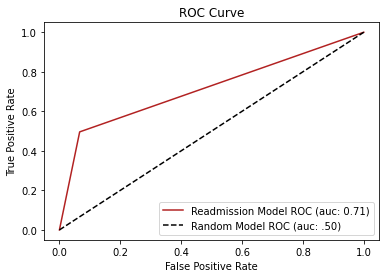

In [71]:
plot_roc_curve(fpr, tpr, roc_auc)

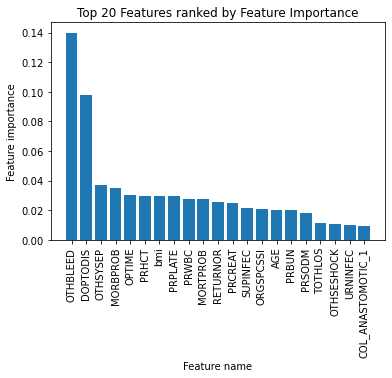

In [72]:
plt.bar(imp.index[0:21], imp.importance[0:21])
plt.xticks(rotation = 'vertical')
plt.xlabel('Feature name')
plt.ylabel('Feature importance')
plt.title('Top 20 Features ranked by Feature Importance')
plt.show()

# Logistic Regression for just the Features that have > 30k nulls

In [59]:
import statsmodels.api as sm

In [65]:
#only 4X values here
X_60k = clean_data[nulls_g30k]
X_60k['y'] = clean_data['target']
X_60k.dropna(inplace = True)
X_60k.shape

<ipython-input-65-390e2dab4cb7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_60k['y'] = clean_data['target']
<ipython-input-65-390e2dab4cb7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_60k.dropna(inplace = True)


(171167, 5)

In [66]:
y = X_60k['y']
X_60k.drop(['y'], axis = 1, inplace = True)
X_6train, X_6test, y_6train, y6_test = train_test_split(X_60k, y, test_size = .3, random_state = 42)

/Users/saraokun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [67]:
lg = sm.Logit(y_6train, X_6train).fit()

Optimization terminated successfully.
         Current function value: 0.340647
         Iterations 6


In [68]:
lg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               119816
Model:                          Logit   Df Residuals:                   119812
Method:                           MLE   Df Model:                            3
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:               -0.004638
Time:                        11:35:17   Log-Likelihood:                -40815.
converged:                       True   LL-Null:                       -40627.
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRALBUM       -0.5286      0.005   -102.309      0.000      -0.539      -0.518
PRBILI        -0.2005      0.021     -9.678      0.000      -0.241      -0.160
PRSGOT        -0.0021      0.000     -5.528      0.000      -0.003      -0.001
PRALKPH       -0.0002      0.000     -1.083      0.279      -0.001       0.000
==============================================================================
"""

In [69]:
X_6train.shape

(119816, 4)

In [70]:
X_30k = clean_data[nulls_le30k]
X_30k['y'] = clean_data['target']
X_30k.dropna(inplace = True)
X_30k.shape

<ipython-input-70-c903324831b7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_30k['y'] = clean_data['target']
<ipython-input-70-c903324831b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_30k.dropna(inplace = True)


(222647, 10)

In [71]:
y = X_30k['y']
X_30k.drop(['y'], axis = 1, inplace = True)
X_3train, X_3test, y_3train, y3_test = train_test_split(X_30k, y, test_size = .3, random_state = 42)

/Users/saraokun/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [72]:
lg30 = sm.Logit(y_3train, X_3train).fit()
lg30.summary()

Optimization terminated successfully.
         Current function value: 0.328334
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               155852
Model:                          Logit   Df Residuals:                   155843
Method:                           MLE   Df Model:                            8
Date:                Sat, 16 Oct 2021   Pseudo R-squ.:                0.005973
Time:                        11:44:43   Log-Likelihood:                -51172.
converged:                       True   LL-Null:                       -51479.
Covariance Type:            nonrobust   LLR p-value:                1.405e-127
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PRSODM        -0.0093      0.000    -19.909      0.000      -0.010      -0.008
PRBUN         -0.0007      0.001     -0.808      0.419      -0.002       0.001
PRCREAT        0.0557      0.012      4.743      0.000       0.033       0.079
PRWBC          0.0107      0.002      6.130      0.000       0.007       0.014
PRHCT         -0.0257      0.001    -17.979      0.000      -0.029      -0.023
PRPLATE       -0.0002   8.24e-05     -2.592      0.010      -0.000   -5.21e-05
TOTHLOS        0.0733      0.070      1.042      0.297      -0.065       0.211
HTOODAY       -0.0639      0.070     -0.908      0.364      -0.202       0.074
DOPTODIS      -0.0748      0.070     -1.064      0.287      -0.213       0.063
==============================================================================
"""

# Feature exploration

In [121]:
nulls_60k = pd.DataFrame(clean_data[nulls_g30k])

In [122]:
nulls_60k.shape

(253714, 4)

In [123]:
index = []
for c in nulls_g30k:
    index.append(np.where(nulls_60k[c].isnull() == True)[0])

In [124]:
nulls_60k.isnull().sum()

PRALBUM    68905
PRBILI     69009
PRSGOT     73871
PRALKPH    69099
dtype: int64

In [125]:
np.array(index).flatten()

<ipython-input-125-fc80de71c27a>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.array(index).flatten()


array([array([     3,      4,      5, ..., 253704, 253710, 253713]),
       array([     3,      4,      5, ..., 253704, 253710, 253713]),
       array([     3,      4,      5, ..., 253708, 253710, 253713]),
       array([     3,      4,      5, ..., 253704, 253710, 253713])],
      dtype=object)

In [126]:
comm1 = np.intersect1d(index[0], index[1])

In [127]:
comm2 = np.intersect1d(comm1, index[2])

In [128]:
len(comm2)/nulls_60k.PRSGOT.isnull().sum()

0.8103450609846895

In [129]:
nulls_60k.corr()

,PRALBUM,PRBILI,PRSGOT,PRALKPH
PRALBUM,1.000000,-0.061233,-0.094698,-0.161331
PRBILI,-0.061233,1.000000,0.201702,0.130322
PRSGOT,-0.094698,0.201702,1.000000,0.233456
PRALKPH,-0.161331,0.130322,0.233456,1.000000


In [130]:
import seaborn as sns
import matplotlib.pyplot as plt

In [131]:
sub = temp_data[['DOPTODIS', 'TOTHLOS', 'target']]

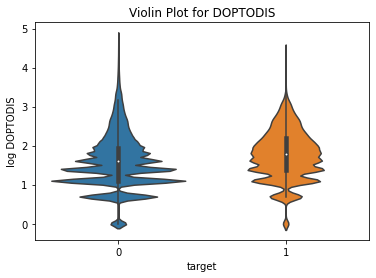

In [132]:
sns.violinplot(sub['target'], np.log(sub['DOPTODIS'], where = (sub['DOPTODIS']> 0.0)))
plt.title('Violin Plot for DOPTODIS')
plt.ylabel('log DOPTODIS')
plt.show()

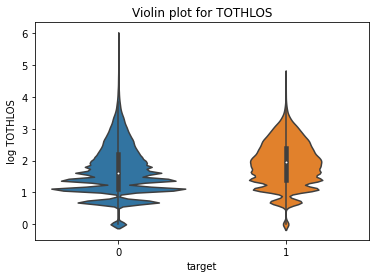

In [133]:
sns.violinplot(sub['target'], np.log(sub['TOTHLOS'], where = (sub['TOTHLOS'] > 0)))
plt.title('Violin plot for TOTHLOS')
plt.ylabel('log TOTHLOS')
plt.show()

In [134]:
from scipy.stats import wilcoxon

In [135]:
wilcoxon(sub.DOPTODIS, sub.target)

WilcoxonResult(statistic=182815.5, pvalue=0.0)

In [136]:
wilcoxon(sub.TOTHLOS, sub.target)

WilcoxonResult(statistic=137402.0, pvalue=0.0)

# Upsampling minority class

In [73]:
from sklearn.utils import resample
def upsample(X, y):
    idx_class_1 = np.where(y == 1)[0]
    class_1 = X.iloc[idx_class_1]
    n_resample = len(X) - len(idx_class_1)
    X_upsampled = resample(class_1, n_samples = n_resample, random_state = 42)
    y_upsampled = y.loc[X_upsampled.index]
    X_up = pd.concat([X_upsampled, X.iloc[np.where(y == 0)[0]]])
    y_up = pd.concat([y_upsampled, y.iloc[np.where(y == 0)[0]]])
    
    return X_up, y_up

In [74]:
X_train_up, y_train_up = upsample(X_train, y_train)

In [75]:
X_train_up.shape

(269700, 295)

# Compare models

In [92]:
fpr_up, tpr_up, roc_auc_up, imp_up = run_baseline_dt(X_train_up, y_train_up, X_val, y_val)

In [93]:
roc_auc_up

0.7021582934318403

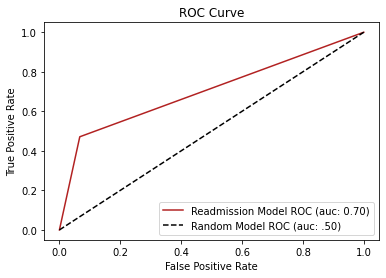

In [94]:
plot_roc_curve(fpr_up, tpr_up, roc_auc_up)

In [138]:
imp_up

,importance
OTHBLEED,0.083979
MORBPROB,0.063792
DOPTODIS,0.062672
RETURNOR,0.048531
OPTIME,0.038814
PRHCT,0.037994
bmi,0.037908
PRPLATE,0.036864
MORTPROB,0.036604
COL_ILEUS_1,0.035698


In [81]:
from sklearn.linear_model import LogisticRegression

In [82]:
lg = LogisticRegression(solver='liblinear')
lg.fit(X_train, y_train)
lg_ypred = lg.predict_proba(X_val)[:,1]

In [95]:
fpr_lg, tpr_lg, thresholds = roc_curve(y_val, lg_ypred)
lg_roc_auc = auc(fpr_lg, tpr_lg)
lg_roc_auc

0.5826366098549233

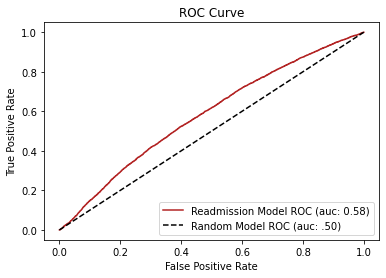

In [96]:
plot_roc_curve(fpr_lg, tpr_lg, lg_roc_auc)

In [88]:
lg.fit(X_train_up, y_train_up)
lg_ypred_up = lg.predict_proba(X_val)[:,1]

In [97]:
fpr_lg_up, tpr_lg_up, thresholds = roc_curve(y_val, lg_ypred_up)
roc_auc_lg_up = auc(fpr_lg_up, tpr_lg_up)
roc_auc_lg_up

0.8203280415397595

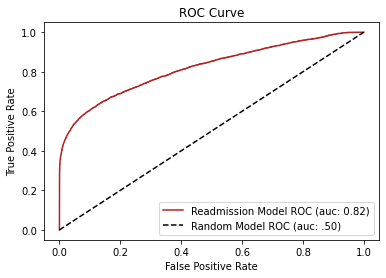

In [91]:
plot_roc_curve(fpr_lg_up, tpr_lg_up, roc_auc_up)

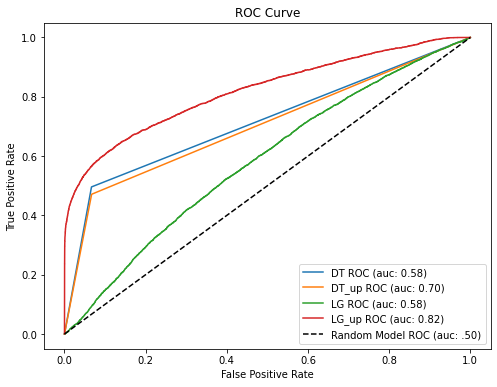

In [116]:
results = [[fpr, tpr, roc_auc], [fpr_up, tpr_up, roc_auc_up], [fpr_lg, tpr_lg, lg_roc_auc], [fpr_lg_up, tpr_lg_up, roc_auc_lg_up]]
models = ['DT', 'DT_up', 'LG', 'LG_up']
count = 0
plt.figure(figsize = (8,6))
for r in results:
    plt.plot(r[0], r[1], label='%s ROC (auc: %.2f)' %(models[count], r[2]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    count += 1
plt.plot([0, 1], [0, 1], color='black', linestyle='--', label = 'Random Model ROC (auc: .50)')
plt.legend(loc = 'lower right')